# Deep Learning: ResNet18 for Quality Control

We use **transfer learning** with **ResNet18** pretrained on ImageNet

##  Imports

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import json

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

# Image processing
from PIL import Image

# Sklearn metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

%matplotlib inline
sns.set_style('whitegrid')

print(" Imports completati!")
print(f"PyTorch version: {torch.__version__}")

seed = 42 
np.random.seed(seed)

 Imports completati!
PyTorch version: 2.4.1+cpu


##  GPU Setup (DirectML per AMD)

In [45]:
# DirectML per AMD GPU
try:
    import torch_directml
    device = torch_directml.device()
    print(f"DirectML device: {device}")
    print("AMD GPU acceleration ENABLED!")
except:
    device = torch.device('cpu')
    print("DirectML not found, using CPU")

DirectML device: privateuseone:0
AMD GPU acceleration ENABLED!


## Configuration

In [46]:
# Paths
DATA_DIR = Path('../data/raw')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
IMG_SIZE = 224  # ResNet usa 224x224

print(f"Train dir: {TRAIN_DIR}")
print(f"Test dir: {TEST_DIR}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")




Train dir: ..\data\raw\train
Test dir: ..\data\raw\test
Batch size: 32
Epochs: 20


## Dataset Class

In [47]:
class CastingDataset(Dataset):
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        ok_dir = self.data_dir / 'ok'
        for img_path in ok_dir.glob('*.jpeg'):
            self.image_paths.append(img_path)
            self.labels.append(0)
        
        def_dir = self.data_dir / 'def_front'
        for img_path in def_dir.glob('*.jpeg'):
            self.image_paths.append(img_path)
            self.labels.append(1)
        
        print(f"Caricati {len(self.image_paths)} immagini")
        print(f"  OK: {self.labels.count(0)}")
        print(f"  Defective: {self.labels.count(1)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('L')
        
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Data Augmentation & Loading

In [ ]:
# Transform for training (con augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

# Transform for test (senza augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_dataset = CastingDataset(TRAIN_DIR, transform=train_transform)
full_val_dataset = CastingDataset(TRAIN_DIR, transform=test_transform)

dataset_size = len(full_train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size)) # 20% per validation

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_subset = Subset(full_train_dataset, train_indices)
val_subset = Subset(full_val_dataset, val_indices) 

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_dataset = CastingDataset(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


print(f"  Train : {len(train_subset)}")
print(f"  Val : {len(val_subset)}")

Caricati 6633 immagini
  OK: 2875
  Defective: 3758
Caricati 6633 immagini
  OK: 2875
  Defective: 3758
Caricati 358 immagini
  OK: 131
  Defective: 227
  Train : 5307
  Val : 1326


### Visualize Batch

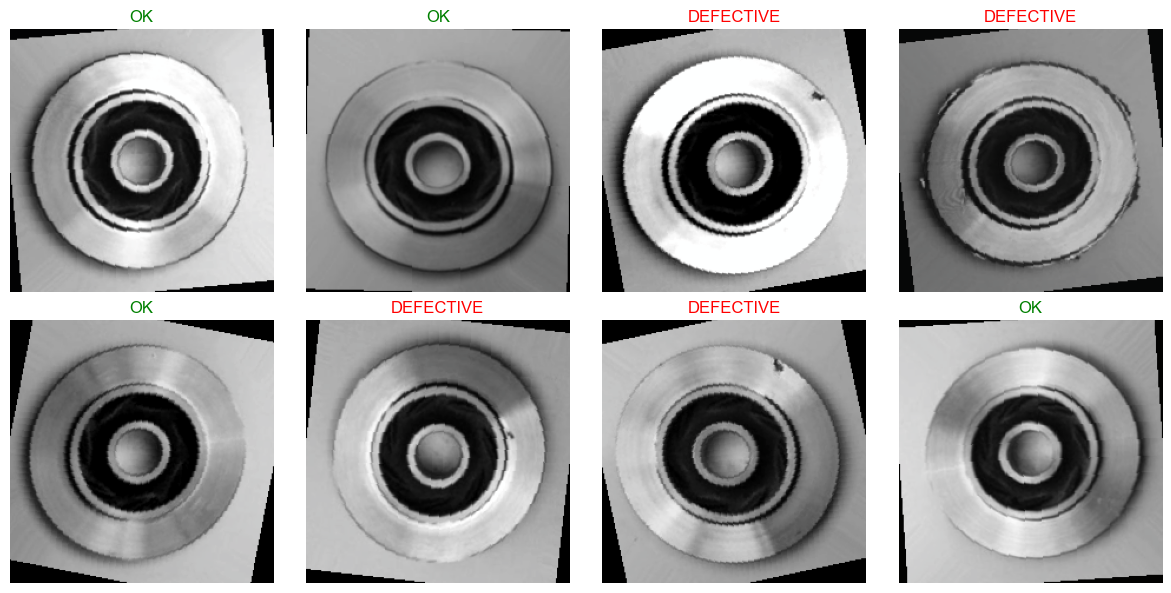

In [49]:

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    label = 'OK' if labels[i] == 0 else 'DEFECTIVE'
    axes[i].set_title(label, color='green' if labels[i] == 0 else 'red')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## ResNet18


In [50]:
# Load ResNet18 pretrained
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify last layer for 2 classes (ok/defective)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Use GPU
model = model.to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Last layer modified: {num_features} → 2 classes")

Total parameters: 11,177,538
Last layer modified: 512 → 2 classes


## Loss & Optimizer

In [51]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(f"Loss: CrossEntropyLoss")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Scheduler: StepLR (step=7, gamma=0.1)")

Loss: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: StepLR (step=7, gamma=0.1)


## Training Loop


In [52]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


def train_epoch(model, loader, criterion, optimizer, device):
    """Training per one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    """Evaluation on test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), 100 * correct / total

# Training!
print("Starting training...\n")
best_acc = 0.0
patience = 0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:  {val_loss:.4f} | Val Acc:  {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), RESULTS_DIR / 'resnet18_best.pth')
        print(f" Best model saved! (Acc: {best_acc:.2f}%)")
    else:
        patience = patience + 1

    if patience == 5:
        break

print(f"\n🎉 Training completed!")
print(f"🏆 Best val accuracy: {best_acc:.2f}%")

Starting training...


Epoch 1/20


Training: 100%|██████████| 166/166 [00:28<00:00,  5.77it/s, loss=0.0142, acc=94.52%]



Results:
  Train Loss: 0.1426 | Train Acc: 94.52%
  Val Loss:  0.0225 | Val Acc:  99.32%
 Best model saved! (Acc: 99.32%)

Epoch 2/20


Training: 100%|██████████| 166/166 [00:28<00:00,  5.78it/s, loss=0.0116, acc=98.13%]



Results:
  Train Loss: 0.0570 | Train Acc: 98.13%
  Val Loss:  0.0514 | Val Acc:  98.27%

Epoch 3/20


Training: 100%|██████████| 166/166 [00:30<00:00,  5.53it/s, loss=0.0036, acc=98.38%]



Results:
  Train Loss: 0.0508 | Train Acc: 98.38%
  Val Loss:  0.0381 | Val Acc:  98.72%

Epoch 4/20


Training: 100%|██████████| 166/166 [00:28<00:00,  5.81it/s, loss=0.0115, acc=99.27%]



Results:
  Train Loss: 0.0259 | Train Acc: 99.27%
  Val Loss:  0.0338 | Val Acc:  98.64%

Epoch 5/20


Training: 100%|██████████| 166/166 [00:28<00:00,  5.83it/s, loss=0.0077, acc=99.42%]



Results:
  Train Loss: 0.0200 | Train Acc: 99.42%
  Val Loss:  0.0089 | Val Acc:  99.85%
 Best model saved! (Acc: 99.85%)

Epoch 6/20


Training: 100%|██████████| 166/166 [00:29<00:00,  5.63it/s, loss=0.0079, acc=98.94%]



Results:
  Train Loss: 0.0317 | Train Acc: 98.94%
  Val Loss:  0.1050 | Val Acc:  96.76%

Epoch 7/20


Training: 100%|██████████| 166/166 [00:28<00:00,  5.84it/s, loss=0.3624, acc=98.64%]



Results:
  Train Loss: 0.0431 | Train Acc: 98.64%
  Val Loss:  0.0498 | Val Acc:  97.96%

🎉 Training completed!
🏆 Best val accuracy: 99.85%


## Plot Training History

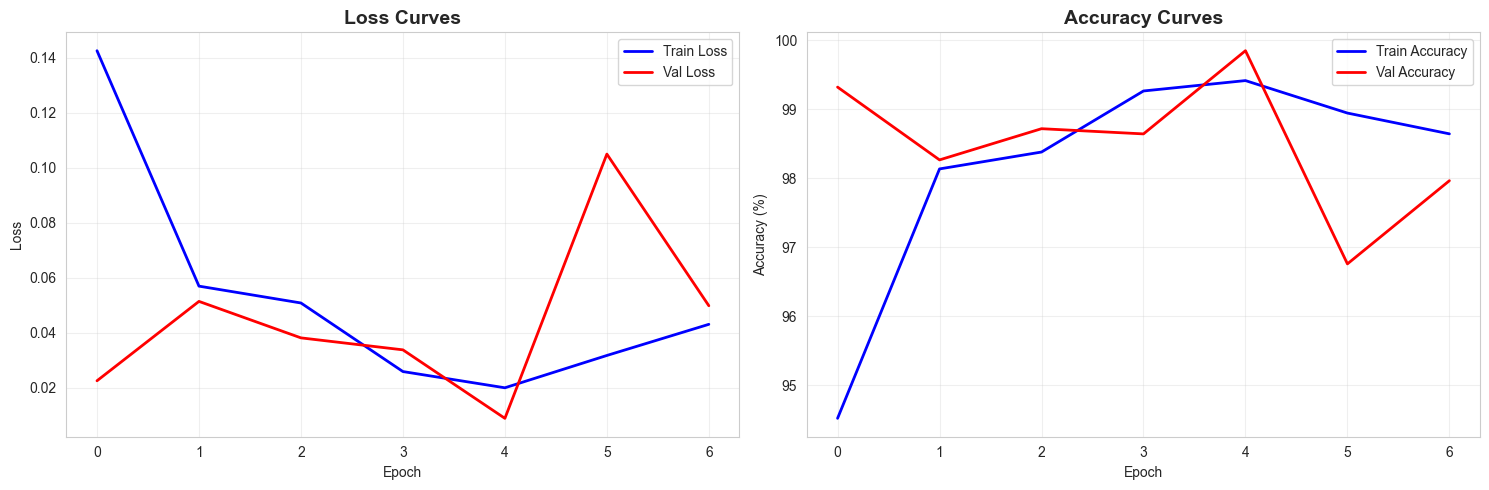

Training curves saved in: ..\results\resnet18_training.png


In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_title('Loss Curves', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
ax2.set_title('Accuracy Curves', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'resnet18_training.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curves saved in: {RESULTS_DIR / 'resnet18_training.png'}")

## Final valutation

In [59]:
# Load best model
model.load_state_dict(torch.load(RESULTS_DIR / 'resnet18_best.pth'))
model.eval()

# Complete predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("Performance on Test Set:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1 Score:  {f1:.4f}")

print("\n" + classification_report(all_labels, all_preds, target_names=['OK', 'Defective']))

C:\Users\rizzo\AppData\Local\Temp\ipykernel_12652\1099715794.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(RESULTS_DIR / 'resnet18_bes

Performance on Test Set:
  Accuracy:  0.9944
  Precision: 0.9956
  Recall:    0.9956
  F1 Score:  0.9956

              precision    recall  f1-score   support

          OK       0.99      0.99      0.99       131
   Defective       1.00      1.00      1.00       227

    accuracy                           0.99       358
   macro avg       0.99      0.99      0.99       358
weighted avg       0.99      0.99      0.99       358



## Confusion Matrix

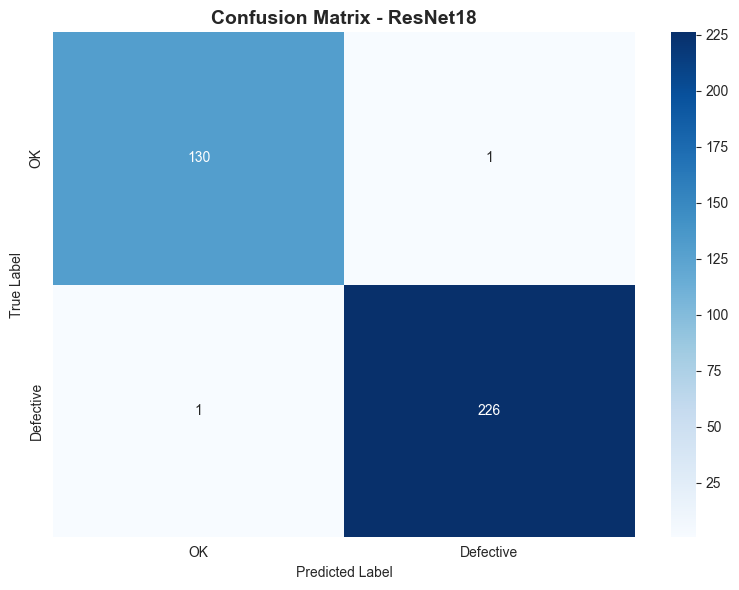

Confusion matrix salvata in: ..\results\resnet18_confusion_matrix.png


In [61]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['OK', 'Defective'],
            yticklabels=['OK', 'Defective'])
plt.title('Confusion Matrix - ResNet18', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'resnet18_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix salvata in: {RESULTS_DIR / 'resnet18_confusion_matrix.png'}")

## Save the results

In [62]:
results = {
    'accuracy': float(acc),
    'precision': float(prec),
    'recall': float(rec),
    'f1_score': float(f1),
    'best_test_acc': float(best_acc),
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    }
}

with open(RESULTS_DIR / 'resnet18_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved in: {RESULTS_DIR / 'resnet18_results.json'}")
print(f"Model saved in: {RESULTS_DIR / 'resnet18_best.pth'}")

Results saved in: ..\results\resnet18_results.json
Model saved in: ..\results\resnet18_best.pth


 Loading ResNet18...


C:\Users\rizzo\AppData\Local\Temp\ipykernel_12652\1295961986.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(RESULTS_DIR / 'resne

 Models loaded!
Generazione predizioni sul Test Set...


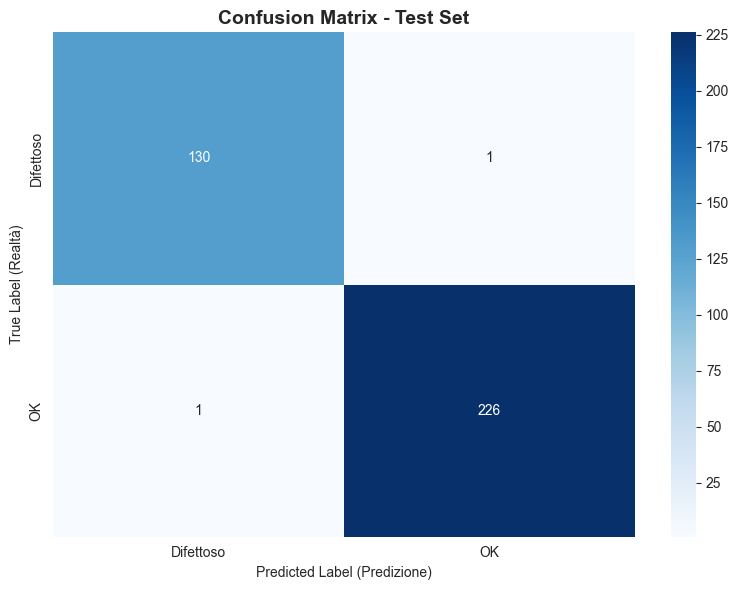

Matrice salvata in: ..\results\resnet18_confusion_matrix_test.png


In [64]:

print(" Loading ResNet18...")
from torchvision.models import resnet18
resnet_model = resnet18(weights=None)
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 2)
resnet_model.load_state_dict(torch.load(RESULTS_DIR / 'resnet18_best.pth', map_location=device))
resnet_model.to(device)
resnet_model.eval()
print(" Models loaded!")

# 1. Preparazione
model.eval()  # Imposta il modello in modalità valutazione (disattiva dropout/batchnorm)
all_preds = []
all_labels = []

# 2. Ciclo di predizione sul Test Set
print("Generazione predizioni sul Test Set...")
with torch.no_grad():  # Disabilita il calcolo del gradiente per risparmiare memoria
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Ottieni la classe predetta (l'indice con il valore più alto)
        _, preds = torch.max(outputs, 1)
        
        # Salva i risultati spostandoli sulla CPU
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Verifica delle classi (Importante!)
# PyTorch assegna gli indici in ordine alfabetico delle cartelle.
# Esempio tipico: 0='def_front' (Defective), 1='ok_front' (OK)
class_names = ['Difettoso', 'OK']

# 4. Calcolo e Plot della Matrice
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, # Usa i nomi reali delle classi
            yticklabels=class_names) # Usa i nomi reali delle classi

plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label (Realtà)')
plt.xlabel('Predicted Label (Predizione)')
plt.tight_layout()

# Salva e mostra
save_path = RESULTS_DIR / 'resnet18_confusion_matrix_test.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Matrice salvata in: {save_path}")
